# Plots - BS, DOS, pDOS, QE, MTE, Murnaghan EOS, Convergence

In [ ]:
import subprocess,os,mmap,sys
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from ase.io import read
from ase.visualize import view
from ase.build import surface
import ase.calculators.castep
import ase.io.castep

from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
from pymatgen.symmetry.kpath import KPathSetyawanCurtarolo,KPathLatimerMunro
from pymatgen.electronic_structure.dos import *
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer


sys.path.append("C:/Users/fcm19/Desktop/PhD/Project/modules_codes/script_share")
from python.bs_plotter_felix_mod.src import *
from python_functions import *
from castep_output_class import *
from optados_output_class import *



In [ ]:
def read_in_debug_file(filename):
    mat_shape = []
    with open(filename,'r') as f:
        next(f)
        line= next(f)
        mat_shape = [int(x) for x in line.split()]
        print("Will return matrix of shape:", mat_shape)
    matrix = np.genfromtxt(filename,skip_header=2,delimiter=' ')
    matrix = np.reshape(matrix,mat_shape, order='F')
    return matrix;
    
def read_qe_calculation_values(filename:str, model:str):
    data = {}
    with open(filename, "r+b") as input:
        mm = mmap.mmap(input.fileno(),0)
        iterator = iter(mm.readline, b"")
        for line in iterator:
            line_temp = line.decode("ANSI").strip()
            if "- Printing list of values going into" in line_temp:
                data['printed_quantities'] = next(iterator).decode("ANSI").strip().split(' - ')
                if model == '3step':
                    data['e_fermi'] = float(next(iterator).decode("ANSI").strip().split()[2])
                    data['data_shape'] = [int(x) for x in next(iterator).decode("ANSI").strip().split()[2:-1]]
                    # print(data['data_shape'])
                    # data['data_shape'] = data['data_shape'][1:] + [data['data_shape'][0]]
                    # print(data['data_shape'])
                if model == '1step':
                    data['data_shape'] = [int(x) for x in next(iterator).decode("ANSI").strip().split()[2:]]
                    data['data_shape'] = data['data_shape'][1:] + [data['data_shape'][0]]
                    # print(data['data_shape'])
                data['values'],data['indices'],data['qe_values'] = [],[],[]
                line_temp = next(iterator).decode("ANSI").strip()
                while "- Finished Printing -" not in line_temp:
                    data['indices'].append([int(x) for x in line_temp.split()[1:-1]])
                    line_temp = next(iterator).decode("ANSI").strip()
                    data['qe_values'].append(float(line_temp.split()[0]))
                    data['values'].append([float(x) for x in line_temp.split()[1:]])
                    line_temp = next(iterator).decode("ANSI").strip()
        mm.close()

        data['values'] = np.array(data['values'])
        data['indices'] = np.array(data['indices'])
        data['qe_values'] = np.array(data['qe_values'])
        #print(data['values'].shape)
        #print(data['values'])
        #data['values'] = np.reshape(data['values'],data['data_shape'])
    return data;
    
# def filter_3step_values(data_in:dict):
#     '''This function takes in a dictionary of raw data and filters out the bands, where the final state is below the\n
#     fermi level and thus assumed to be occupied. This selection rule is a WIP. The information for the atom,\n
#     final state, initial state, spin, and k point are preserved and returned as dict['indices'].'''
#     data_out = {}
#     data_out['printed_quantities'] = data_in['printed_quantities']
#     data_out['original_shape'] = data_in['data_shape']
#     indices = np.empty(data_in['data_shape'][:-1],dtype=object)
#     for m in range( data_in['data_shape'][4]): # K point
#         for l in range( data_in['data_shape'][3]): # Spin
#             for k in range( data_in['data_shape'][2]): # Final State
#                 for j in range( data_in['data_shape'][1]): # Initial State
#                     for i in range( data_in['data_shape'][0]): # Layer
#                         indices[i,j,k,l,m] = f"{i}-{j}-{k}-{l}-{m}"
#     indices = indices.flatten(order='F')
#     filter_array = data_in['values'][:,0] > data_in['e_fermi']
#     data_out['values'] = data_in['values'][filter_array]
#     data_out['indices'] = indices[filter_array]
#     return data_out;
    

In [ ]:
directory = "./OD_debug_files/OptaDOS_debug_output/4-added_singular_value_printing/"
file = 'Ag100_fine_grid_4.7_1step_0.1_iprint_5.odo'
filename = directory + file 
one_step_point1 = read_qe_calculation_values(filename,model='1step')
print(one_step_point1['printed_quantities'])
print(one_step_point1['data_shape'])
print(one_step_point1['values'][0,0,0,0,:])

In [ ]:
for i in range(len(one_step_point1['values'][0,:,0,0,0])):
    if one_step_point1['values'][0,i,0,0,1] > 0:
        print(i)
        print(one_step_point1['values'][0,i,0,0,:])

In [ ]:
directory = "./OD_debug_files/OptaDOS_debug_output/4-added_singular_value_printing/"
file = 'Ag100_fine_grid_4.7_1step_0.001_iprint_5.odo'
filename = directory + file 
one_step_point001 = read_qe_calculation_values(filename,model='1step')
print(one_step_point001['printed_quantities'])
print(one_step_point001['data_shape'])
print(one_step_point001['values'][0,0,0,0,:])


In [ ]:
directory = "./OD_debug_files/OptaDOS_debug_output/4-added_singular_value_printing/"
file = 'Ag100_fine_grid_4.7_3step_0.1_iprint_5.odo'
filename = directory + file 
three_step_point1 = read_qe_calculation_values(filename,model='3step')

In [ ]:
filtered_three_step_point1 = filter_3step_values(three_step_point1)

In [ ]:
temp_array = filtered_three_step_point1['values'][:,2:13]
print(temp_array.shape)
print(temp_array[0])
print(len(temp_array))
for i in range(len(temp_array)):
    if not np.any(temp_array[i] == 0):
        print(i)
        print(filtered_three_step_point1['indices'][i])


In [ ]:
for i in range(len(temp_array[0])):
    print(filtered_three_step_point1['printed_quantities'][i+1],np.sum(temp_array[:,i]))

In [ ]:
print(three_step_point1['values'][0:3,0,0,0,0,:])

In [ ]:
directory = './OD_debug_files/OD_visualisation_tests/XGMX_bs_path/bs_test/'
file = 'Ag100_fine_grid_4.2_3step_0.1_20_5_bs_path.odo'
filename = directory + file 
three_step_bspath = read_qe_calculation_values(filename,model='3step')
print(three_step_bspath['values'].shape)
print(three_step_bspath['printed_quantities'])
print(three_step_bspath['qe_values'][0])
print(three_step_bspath['values'][0,:])
three_step_bspath['indices'][0,:]
# filtered_three_step_bspath = filter_3step_values(three_step_bspath)
# print(filtered_three_step_bspath['values'][0])
# print(filtered_three_step_bspath['indices'][0])
# print(three_step_bspath['data_shape'])

In [ ]:
filter_array = three_step_bspath['qe_values']> 0.0 
filtered_qe =  three_step_bspath['qe_values'][filter_array]
filtered_indices = three_step_bspath['indices'][filter_array]
filtered_values = three_step_bspath['values'][filter_array]
print(filtered_indices.shape)
print(filtered_qe.shape)
print(filtered_values.shape)
print(filtered_indices[0])
print(filtered_qe[0])
print(filtered_values[0])
with open("./OD_debug_files/OD_visualisation_tests/XGMX_bs_path/bs_test/filtered_qe_contributions.dat",'w') as f:
    f.write(str(three_step_bspath['printed_quantities'][1:])+'\n')
    f.write('Fermi Energy = ' + str(round(three_step_bspath['e_fermi'],6)) + '\n')
    for index in range(len(filtered_indices)):
        f.write('Atom, Psi_i, Psi_f, Spin, K-pt\n')
        f.write(str(filtered_indices[index])+'\n')
        f.write(str(filtered_qe[index])+'\n')
        for i in range(filtered_values.shape[1]):
            f.write(str(filtered_values[index,i])+'  ')
        f.write('\n')
print("I am DONE :D")

In [ ]:
directory = "./OD_debug_files/OptaDOS_debug_output/4-added_singular_value_printing/"
file = 'Ag100_fine_grid_4.7_3step_0.001_iprint_5.odo'
filename = directory + file 
three_step_point001 = read_qe_calculation_values(filename,model='3step')
print(three_step_point001['values'].shape)
three_step_point001['loop_lengths'] = [13] + three_step_point001['loop_lengths']
three_step_point001['values'] = np.reshape(three_step_point001['values'].flatten(order='C'),three_step_point001['loop_lengths'],order='F')
print(three_step_point001['values'].shape)
print(three_step_point001['printed_data'])

In [ ]:
directory ="./OD_debug_files/OptaDOS_debug_output/3-added_delta_function_printing/" 
file = "Ag100_3step_delta_function.txt"
filename = directory + file
delta_function = read_in_debug_file(filename)

In [ ]:
from matplotlib.colors import LogNorm
fields = np.zeros([237,237])
print(fields.shape)
indices = []
for k in range(36):
    if np.sum(delta_function[:,:,k]) != 0:
        print("Index", k, "=", np.sum(delta_function[:,:,k]))
        for j in range(237):
            for i in range(237):
                if delta_function[i,j,k] != 0:
                    #print(k,j, np.sum(delta_function[:,j,k]))
                    fields[i,j] += 1
        indices.append(k)
fig, axes = plt.subplots(3,3,figsize=(20,20),dpi=200)
for i,ax in enumerate(axes.ravel()):
    if i == len(axes.ravel())-1:
        ax.imshow(fields)#,norm=LogNorm(vmin=0,vmax=np.max(fields)))
        ax.set(title="Boolean plot showing if the \ndelta function is /= 0 on any K-Point",xlabel='Final state',ylabel='Initial State')
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
    else:
        minimum = np.min(delta_function[:,:,indices[i]])
        maximum = np.max(delta_function[:,:,indices[i]]) 
        ax.imshow(delta_function[:,:,indices[i]])#,norm=LogNorm(vmin=minimum,vmax=maximum))
        ax.set(title=f'K-Point #{1 + indices[i]}',xlabel='Final state',ylabel='Initial State')
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
plt.savefig('./OD_debug_files/Ag100_delta_func_237_237_36.png')
#axes.matshow(fields)
#(xlabel='Final State',ylabel = 'Initial State')
print("max(fields) = " ,np.max(fields))
print("min(delta function values) = ",np.min(delta_function))

In [ ]:
from matplotlib.colors import LogNorm
fields = np.zeros([237,237])
for k in range(36):
    if np.sum(delta_function[:,:,k]) != 0:
        # print("Index", k, "=", np.sum(delta_function[:,:,k]))
        # for j in range(237):
        #     if np.sum(delta_function[:,j,k]):
        #         # print(k,j, np.sum(delta_function[:,j,k]))
        #         fields[j,k] += 1
        #         #fig, axes = plt.subplots(1,1,figsize=(20,20))
        minimum = np.min(delta_function[:,:,k])
        maximum = np.max(delta_function[:,:,k]) 
        fig, ax = plt.subplots(1,1,figsize=(10,10),dpi=200)
        ax.imshow(delta_function[:,:,k])#,norm=LogNorm(vmin=minimum,vmax=maximum))
        ax.set(xlabel='Final state',ylabel='Initial State',)
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()

In [ ]:
directory ="./OD_debug_files/OptaDOS_debug_output/3-added_delta_function_printing/" 
file = "Ag100_3step_QE_matrix.txt"
filename = directory + file
qe_matrix = read_in_debug_file(filename)

In [ ]:
def real_to_rec_lattice(real):
    reciprocal = np.zeros((3,3))
    V = np.dot(real[0],np.cross(real[1],real[2]))
    reciprocal[0] = np.cross(real[1],real[2])*(2*np.pi/V)
    reciprocal[1] = np.cross(real[2],real[0])*(2*np.pi/V)
    reciprocal[2] = np.cross(real[0],real[1])*(2*np.pi/V)
    return reciprocal;

def get_scaled_distances(cartesian):
    moved = np.insert(cartesian, 0, cartesian[0]).reshape((np.shape(cartesian)[0]+1,np.shape(cartesian)[1]))
    cart_diff = cartesian - moved[:-1]
    distances = np.linalg.norm(cart_diff,axis=1)
    for idx, i in enumerate(distances):
        if idx == 0:
            continue
        distances[idx] = distances[idx-1] + distances[idx]
    scaled_distances = distances/np.nanmax(distances)
    return scaled_distances;

def read_bands_file(path:str):
    hartree2eV = 27.21139664
    bohr2ang = 0.529177249
    lattice = []
    data = {}
    with open(path,'r') as f:
        lines = f.readlines()
    num_kpoints = int(lines[0].strip().split()[3])
    num_spins = int(lines[1].strip().split()[4])
    num_bands = int(lines[3].strip().split()[3])
    fermi_e = float(lines[4].strip().split()[5])*hartree2eV
    for i in range(3):
        lattice.append([float(x)*bohr2ang for x in lines[6+i].strip().split()])
    rec_lattice = real_to_rec_lattice(lattice)
    data['reciprocal_lattice'] = rec_lattice
    kpt_cart = np.zeros((num_kpoints,3))
    kpt_frac = np.zeros((num_kpoints,3))
    eigenvalues_efermi = np.zeros((num_bands, num_spins, num_kpoints))
    length_kpt_block = (num_bands+1)*num_spins+1
    for k in range(num_kpoints):
        kpt_line_index = 9+k*length_kpt_block
        frac=np.array([float(x) for x in lines[kpt_line_index].strip().split()[2:5]])
        kpt_cart[k] = np.dot(rec_lattice,frac)
        kpt_frac[k] = frac
        for j in range(num_spins):
            for i in range(num_bands):
                line_index = kpt_line_index + j*(num_bands+1)+i+2
                eigenvalues_efermi[i,j,k] = float(lines[line_index].strip().split()[0])*hartree2eV-fermi_e
    data['scaled_kpt_path'] = get_scaled_distances(kpt_cart)
    data['eigenval_efermi_0'] = eigenvalues_efermi
    data['kpt_cart'] = kpt_cart
    data['kpt_frac'] = kpt_frac
    data['num_eigen'] = num_bands
    data['num_kpt'] = num_kpoints
    return data;

In [ ]:
data_matrices = {'norm':{},'test':{}}
file_bands = './OD_debug_files/OD_visualisation_tests/Ag100_fine_grid.bands'
data_bands = read_bands_file(file_bands)

In [ ]:
energies = np.linspace(4.79,4.85,7)
keywords = [['norm',''],['test','_test']]
#energies =[4.85]
for keyword in keywords:
    for energy in energies:
        file = f'./OD_debug_files/OD_visualisation_tests/iprint_6/Ag100_fine_grid_{energy:.2f}_3step_0.01_20_6{keyword[1]}.odo'
        data = read_qe_matrix_values(file)
        data_matrices[keyword[0]][round(energy,2)] = data
        print(f'{energy:.2f}')

In [ ]:
import matplotlib.colors as mlp
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(12,5),dpi=200)
ax = fig.add_subplot()
qe_sum = np.zeros((7,237,36))
energies = np.linspace(4.79,4.85,7)

for idx,energy in enumerate(energies[:-1]):
    qe_sum[idx,:,:] = np.sum(data_matrices['test'][round(energy,2)]['matrix'],axis=(1,3,4))
norm = mlp.Normalize(vmin=0, vmax=np.nanmax(qe_sum))
for idx,energy in enumerate(energies[:-1]):
    x_val = np.full((237),round(energy,2))
    for i in range(np.shape(qe_sum)[2]):
        if np.sum(qe_sum[idx,:,i]) > 0:
            alphas = qe_sum[idx,:,i]/np.nanmax(qe_sum[idx,:,i])
            ax.scatter(x = x_val, y = data_bands['eigenval_efermi_0'][:,0,i],cmap='cividis',c= norm(qe_sum[idx,:,i]),marker='.',alpha=alphas)
            ax.set_xlabel('Photon Energy [eV]')
            ax.set_ylabel(r'$E - E_F$ [eV]')
            ax.set_facecolor('white')
    for j in range(np.shape(qe_sum)[2]):
        if np.sum(qe_sum[idx,:,j]) > 0:
            print(np.nanmax(qe_sum[idx,:,j]))
            print(np.sum(qe_sum[idx,:,:]))
            for k in range(237):
                if abs(np.nanmax(qe_sum[idx,:,j]) - qe_sum[idx,k,j]) < 1E-12:
                    ax.annotate(str(qe_sum[idx,k,j]),xy=[energies[idx],data_bands['eigenval_efermi_0'][k,0,j]],xytext=[5,5],textcoords='offset pixels')
plt.title(f"QE contribution from bands at Kpoint {data_matrices['norm'][4.79]['kpoints'][16]}")
plt.ylim(-10,35)
plt.savefig('./OD_debug_files/OD_visualisation_tests/Ag100_band_emission_near_edge_comp_OD_test.png')

In [ ]:

energies = np.linspace(4.4,4.7,4)
model = '3step'
iprint = 7
for energy in energies:
    file = f'./OD_debug_files/OD_visualisation_tests/15_15_iprint_7/Ag100_fine_grid_{energy:.2f}_3step_0.1_20_7.odo'
    print(file)
    data = read_qe_matrix_values(file)
    #data_matrices['test'][round(energy,2)] = data
    #print(round(energy,2))
    if data['model'] == '3step' and iprint == 6:
        qe_sum = np.sum(data['matrix'],axis = (0,1,3,4))
    elif data['model'] == '1step' or iprint == 7:
        qe_sum = np.sum(data['matrix'],axis = (0,2,3))
    #plt.style.use('seaborn-bright')
    #print(plt.style.available)
    half_bz = 2.193102/2
    fig = plt.figure(figsize=(8,8),dpi=200)
    ax = fig.add_subplot()
    ax.scatter(data['kpoints'][:,0],data['kpoints'][:,1],cmap='viridis',c=qe_sum/np.nanmax(qe_sum))
    ax.plot([0,0,half_bz,0],[half_bz,0,half_bz,half_bz],c='tab:green')
    ax.xaxis.tick_top()
    ax.set_xlabel(r'Recip lattice vector $\vec{b}_1$ $\AA^{-1}$')  
    ax.set_ylabel(r'Recip lattice vector $\vec{b}_2$ $\AA^{-1}$')  
    ax.xaxis.set_label_position('top') 
    ax.set_facecolor('white')
    plt.title(f'Summed QE for each K-Point with Photon Energy @ {energy:.2f}\nTotal QE = {np.sum(qe_sum):.4E}')
    plt.annotate('X',[0,half_bz],[-20,20],textcoords='offset pixels',fontweight='bold',fontsize = 'large')
    plt.annotate(r'$\bf{\Gamma}$',1,[-24,-24],textcoords='offset pixels',fontweight='bold',fontsize = 'large')
    plt.annotate('M',[half_bz,half_bz],[15,15],textcoords='offset pixels',fontweight='bold',fontsize = 'large')
    for i in range(np.shape(qe_sum)[0]):
        if qe_sum[i] > 1E-50:
            plt.annotate(f'{qe_sum[i]:.6E}',data['kpoints'][i,:2],[10,10],textcoords='offset pixels')
    plt.tight_layout()
    plt.rcParams.update({
        "savefig.facecolor": (1.0, 1.0, 1.0, 1),
    })
    plt.savefig(f'./OD_debug_files/OD_visualisation_tests/Ag100_QE_15_15_kpt_visual_{energy:.2f}.png')

In [ ]:
path = './OD_debug_files/OD_visualisation_tests/Ag100_fine_grid.bands.spec'
more_bands = read_bands_file(path)
for item in more_bands['kpt_frac']:
    print(item[0], item[1], item[2], f"1/{np.shape(more_bands['kpt_frac'])[0]}")

## Plotting 3D Data of QE for a MP-like k grid

### Setup

In [ ]:
import subprocess,os,mmap,sys
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from ase.io import read
from ase.visualize import view
from ase.build import surface
import ase.calculators.castep
import ase.io.castep

from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
from pymatgen.symmetry.kpath import KPathSetyawanCurtarolo,KPathLatimerMunro
from pymatgen.electronic_structure.dos import *
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer


sys.path.append("C:/Users/fcm19/Desktop/PhD/Project/modules_codes/script_share")
from python.bs_plotter_felix_mod.src import *
from python_functions import *
from castep_output_class import *
from optados_output_class import *

In [ ]:
def real_to_rec_lattice(real):
    reciprocal = np.zeros((3,3))
    V = np.dot(real[0],np.cross(real[1],real[2]))
    reciprocal[0] = np.cross(real[1],real[2])*(2*np.pi/V)
    reciprocal[1] = np.cross(real[2],real[0])*(2*np.pi/V)
    reciprocal[2] = np.cross(real[0],real[1])*(2*np.pi/V)
    return reciprocal;

def get_scaled_distances(cartesian):
    moved = np.insert(cartesian, 0, cartesian[0]).reshape((np.shape(cartesian)[0]+1,np.shape(cartesian)[1]))
    cart_diff = cartesian - moved[:-1]
    distances = np.linalg.norm(cart_diff,axis=1)
    for idx, i in enumerate(distances):
        if idx == 0:
            continue
        distances[idx] = distances[idx-1] + distances[idx]
    scaled_distances = distances/np.nanmax(distances)
    return scaled_distances;
    
def read_bands_file(path:str):
    hartree2eV = 27.21139664
    bohr2ang = 0.529177249
    lattice = []
    data = {}
    with open(path,'r') as f:
        lines = f.readlines()
    num_kpoints = int(lines[0].strip().split()[3])
    num_spins = int(lines[1].strip().split()[4])
    num_bands = int(lines[3].strip().split()[3])
    fermi_e = float(lines[4].strip().split()[5])*hartree2eV
    for i in range(3):
        lattice.append([float(x)*bohr2ang for x in lines[6+i].strip().split()])
    rec_lattice = real_to_rec_lattice(lattice)
    data['reciprocal_lattice'] = rec_lattice
    kpt_cart = np.zeros((num_kpoints,3))
    kpt_frac = np.zeros((num_kpoints,3))
    eigenvalues_efermi = np.zeros((num_bands, num_spins, num_kpoints))
    length_kpt_block = (num_bands+1)*num_spins+1
    for k in range(num_kpoints):
        kpt_line_index = 9+k*length_kpt_block
        frac=np.array([float(x) for x in lines[kpt_line_index].strip().split()[2:5]])
        kpt_cart[k] = np.dot(rec_lattice,frac)
        kpt_frac[k] = frac
        for j in range(num_spins):
            for i in range(num_bands):
                line_index = kpt_line_index + j*(num_bands+1)+i+2
                eigenvalues_efermi[i,j,k] = float(lines[line_index].strip().split()[0])*hartree2eV-fermi_e
    data['scaled_kpt_path'] = get_scaled_distances(kpt_cart)
    data['eigenval_efermi_0'] = eigenvalues_efermi
    data['kpt_cart'] = kpt_cart
    data['kpt_frac'] = kpt_frac
    data['num_eigen'] = num_bands
    data['num_kpt'] = num_kpoints
    return data;

def read_qe_matrix_values(filename:str):
    data = {}
    with open(filename, "r+b") as input:
            mm = mmap.mmap(input.fileno(),0)
            iterator = iter(mm.readline, b"")
            for line in iterator:
                line_temp = line.decode("ANSI").strip()
                if 'K-Points in Cartesian Coordinates' in line_temp:
                    line = next(iterator).decode("ANSI")
                    kpoints = []
                    while not 'Finished Printing' in line:
                        #print(line)
                        kpoints.append([float(x) for x in line.strip().split()])
                        line = next(iterator).decode("ANSI")
                    data['kpoints'] = np.array(kpoints)
                if 'QE Matrix --' in line_temp:
                    data['model'] = line_temp.strip().split()[2]
                    temp = next(iterator)
                    shape = [int(x) for x in next(iterator).decode("ANSI").strip().split()]
                    matrix = []
                    line = next(iterator).decode("ANSI")
                    while not 'Finished Printing' in line:
                        matrix.append([float(x) for x in line.strip().split()]) 
                        line = next(iterator).decode("ANSI")
                    matrix = np.array(matrix)
            mm.close()
            data['matrix'] = np.reshape(matrix.flatten(order='C'),shape,order = 'F')
    return data;
    

In [17]:
data_1step_matrices = {'norm':{},'test':{},'xgmx_bs':{},'shift':{}}
data_1step_odo = {'norm':{},'test':{},'xgmx_bs':{},'shift':{}}
energies = np.linspace(4.2,6.5,24)
energies = [4.2,4.3,4.4]
for energy in energies:
    file = f'./OD_debug_files/OD_visualisation_tests/16_16_symmetry_shift/1step_iprint7/Ag100_fine_grid_{energy:.2f}_1step_0.1_20_7.odo'
    data = read_qe_matrix_values(file)
    odo = OptaDOSOutput(file)
    data_1step_odo['shift'][round(energy,2)] = [odo.qe,odo.mte]
    data_1step_matrices['shift'][round(energy,2)] = data
file_bands = './OD_debug_files/OD_visualisation_tests/16_16_symmetry_shift/Ag100_fine_grid.bands'
data_bands_shift = read_bands_file(file_bands)

In [19]:
print(data_bands_shift['kpt_cart'])

[[-0.95948216 -0.54827552  0.        ]
 [-0.95948216  0.          0.        ]
 [-0.95948216 -1.09655104  0.        ]
 [-0.82241328 -0.95948216  0.        ]
 [-0.82241328  0.          0.        ]
 [-0.82241328 -1.09655104  0.        ]
 [-0.6853444  -0.95948216  0.        ]
 [-0.6853444  -0.6853444   0.        ]
 [-0.6853444   0.          0.        ]
 [-0.54827552 -1.09655104  0.        ]
 [-0.41120664 -0.95948216  0.        ]
 [-0.41120664 -0.82241328  0.        ]
 [-0.41120664 -0.6853444   0.        ]
 [-0.41120664 -0.54827552  0.        ]
 [-0.41120664 -0.41120664  0.        ]
 [-0.41120664 -0.27413776  0.        ]
 [-0.41120664  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.         -1.09655104  0.        ]
 [ 0.13706888 -0.95948216  0.        ]
 [ 0.13706888 -0.82241328  0.        ]
 [ 0.13706888 -0.6853444   0.        ]
 [ 0.13706888 -0.54827552  0.        ]
 [ 0.13706888 -0.41120664  0.        ]
 [ 0.13706888 -0.27413776  0.        ]
 [ 0.13706888 -0.13706888

[array([ True,  True,  True, ...,  True,  True,  True])]
[-0.95948216 -0.95948216 -0.95948216 ... -1.09655104 -1.09655104
 -1.09655104]


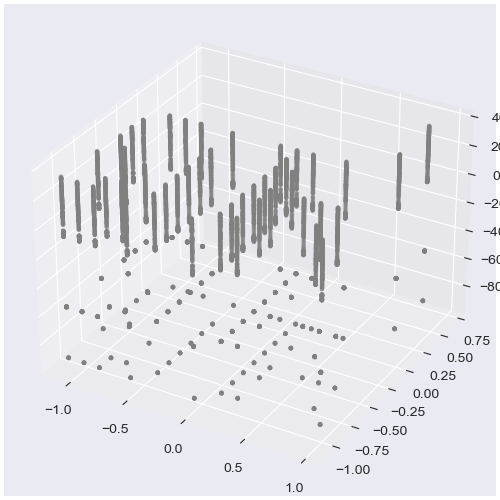

In [89]:
import matplotlib.colors as mlp
import matplotlib as mpl
%matplotlib widget
from matplotlib.widgets import Slider, Button
from matplotlib.gridspec import GridSpec

# qe_sums(eigenvalues, kpoints, energies)
# band_energies(eigenvalues, kpoints)
# band_distances(eigenvalues, kpoints)
# norms(eigenvalues, kpoints, energies)
# alphas(eigenvalues, kpoints, energies)

# SETTING UP THE DATA STRUCTURES

num_eigen = data_bands_shift['num_eigen']
num_kpts = data_bands_shift['num_kpt']
num_energies = len(energies)
num_layers = np.shape(data_1step_matrices['shift'][energies[0]]['matrix'])[-1]
#print(num_layers)

# Setting up all the arrays needed for holding the data
qe_sums = np.zeros((num_eigen,num_kpts, num_energies))
qe_layers = np.zeros((num_layers,num_energies))
qe_totals = np.zeros((num_energies))
mte_values = np.zeros((num_energies))
band_energies = np.zeros((num_eigen,num_kpts))
kpoint_coords = np.zeros((2,num_kpts))
bands_xyz = np.zeros((3,num_kpts, num_eigen))
norms = np.zeros((num_eigen,num_kpts, num_energies))
norms_layers = np.zeros((num_layers,num_energies))
scales = np.zeros((num_eigen,num_kpts, num_energies))

# Filling up the created arrays with the respective data
band_energies = np.sum(data_bands_shift['eigenval_efermi_0'],axis=1)
kpoint_coords = data_bands_shift['kpt_cart'][:,:2]
#print(kpoint_coords[0])
for j in range(num_eigen):
    for i in range(num_kpts):
        bands_xyz[0,i,j] = kpoint_coords[i,0]
        bands_xyz[1,i,j] = kpoint_coords[i,1]
        bands_xyz[2,i,j] = band_energies[j,i]
#print(bands_xyz[:,0,0])
for idx,energy in enumerate(energies):
    temp_matrix = data_1step_matrices['shift'][round(energy,2)]['matrix']
    qe_sums[:,:,idx] = np.sum(temp_matrix,axis=(2,3))
    qe_layers[:,idx] = np.sum(temp_matrix,axis=(0,1,2))
    qe_totals[idx] = np.sum(qe_sums[:,:,idx])
    mte_values[idx] = data_1step_odo['shift'][round(energy,2)][1]

zlimit = [-7.5,10]
bands_xyz = bands_xyz.reshape((3,num_eigen*num_kpts))
test = [(bands_xyz[2]>=zlimit[0]) | (bands_xyz[2]<=zlimit[1])]
print(test)
print(bands_xyz[0])
plt.style.use('seaborn-v0_8-darkgrid')
#plt.ion()
fig = plt.figure(layout='constrained',figsize=(5,5))#,dpi=200)
ax = fig.add_subplot(projection='3d')
scatter_3d = ax.scatter(bands_xyz[0,:],bands_xyz[1,:],bands_xyz[2,:],color='grey',marker='.',alpha=0.5)


# Plotting the QE for a Bandstructure Plot

## Plot an interactive BS plot with QE values superimposed

### Setup

In [ ]:
import subprocess,os,mmap,sys
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

from ase.io import read
from ase.visualize import view
from ase.build import surface
import ase.calculators.castep
import ase.io.castep

from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
from pymatgen.symmetry.kpath import KPathSetyawanCurtarolo,KPathLatimerMunro
from pymatgen.electronic_structure.dos import *
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer


sys.path.append("C:/Users/fcm19/Desktop/PhD/Project/modules_codes/script_share")
from python.bs_plotter_felix_mod.src import *
from python_functions import *
from castep_output_class import *
from optados_output_class import *



In [ ]:
def real_to_rec_lattice(real):
    reciprocal = np.zeros((3,3))
    V = np.dot(real[0],np.cross(real[1],real[2]))
    reciprocal[0] = np.cross(real[1],real[2])*(2*np.pi/V)
    reciprocal[1] = np.cross(real[2],real[0])*(2*np.pi/V)
    reciprocal[2] = np.cross(real[0],real[1])*(2*np.pi/V)
    return reciprocal;

def get_scaled_distances(cartesian):
    moved = np.insert(cartesian, 0, cartesian[0]).reshape((np.shape(cartesian)[0]+1,np.shape(cartesian)[1]))
    cart_diff = cartesian - moved[:-1]
    distances = np.linalg.norm(cart_diff,axis=1)
    for idx, i in enumerate(distances):
        if idx == 0:
            continue
        distances[idx] = distances[idx-1] + distances[idx]
    scaled_distances = distances/np.nanmax(distances)
    return scaled_distances;
    
def read_bands_file(path:str):
    hartree2eV = 27.21139664
    bohr2ang = 0.529177249
    lattice = []
    data = {}
    with open(path,'r') as f:
        lines = f.readlines()
    num_kpoints = int(lines[0].strip().split()[3])
    num_spins = int(lines[1].strip().split()[4])
    num_bands = int(lines[3].strip().split()[3])
    fermi_e = float(lines[4].strip().split()[5])*hartree2eV
    for i in range(3):
        lattice.append([float(x)*bohr2ang for x in lines[6+i].strip().split()])
    rec_lattice = real_to_rec_lattice(lattice)
    data['reciprocal_lattice'] = rec_lattice
    kpt_cart = np.zeros((num_kpoints,3))
    kpt_frac = np.zeros((num_kpoints,3))
    eigenvalues_efermi = np.zeros((num_bands, num_spins, num_kpoints))
    length_kpt_block = (num_bands+1)*num_spins+1
    for k in range(num_kpoints):
        kpt_line_index = 9+k*length_kpt_block
        frac=np.array([float(x) for x in lines[kpt_line_index].strip().split()[2:5]])
        kpt_cart[k] = np.dot(rec_lattice,frac)
        kpt_frac[k] = frac
        for j in range(num_spins):
            for i in range(num_bands):
                line_index = kpt_line_index + j*(num_bands+1)+i+2
                eigenvalues_efermi[i,j,k] = float(lines[line_index].strip().split()[0])*hartree2eV-fermi_e
    data['scaled_kpt_path'] = get_scaled_distances(kpt_cart)
    data['eigenval_efermi_0'] = eigenvalues_efermi
    data['kpt_cart'] = kpt_cart
    data['kpt_frac'] = kpt_frac
    data['num_eigen'] = num_bands
    data['num_kpt'] = num_kpoints
    return data;

In [ ]:
def read_qe_matrix_values(filename:str):
    data = {}
    with open(filename, "r+b") as input:
            mm = mmap.mmap(input.fileno(),0)
            iterator = iter(mm.readline, b"")
            for line in iterator:
                line_temp = line.decode("ANSI").strip()
                if 'K-Points in Cartesian Coordinates' in line_temp:
                    line = next(iterator).decode("ANSI")
                    kpoints = []
                    while not 'Finished Printing' in line:
                        #print(line)
                        kpoints.append([float(x) for x in line.strip().split()])
                        line = next(iterator).decode("ANSI")
                    data['kpoints'] = np.array(kpoints)
                if 'QE Matrix --' in line_temp:
                    data['model'] = line_temp.strip().split()[2]
                    temp = next(iterator)
                    shape = [int(x) for x in next(iterator).decode("ANSI").strip().split()]
                    matrix = []
                    line = next(iterator).decode("ANSI")
                    while not 'Finished Printing' in line:
                        matrix.append([float(x) for x in line.strip().split()]) 
                        line = next(iterator).decode("ANSI")
                    matrix = np.array(matrix)
            mm.close()
            data['matrix'] = np.reshape(matrix.flatten(order='C'),shape,order = 'F')
    return data;
    


### 3step

In [ ]:
data_3step_matrices = {'norm':{},'test':{},'xgmx_bs':{}}
data_3step_odo = {'norm':{},'test':{},'xgmx_bs':{}}
energies = np.linspace(4.2,6.5,24)
for energy in energies:
    file = f'./OD_debug_files/OD_visualisation_tests/XGMX_bs_path/3step_7/Ag100_fine_grid_{energy:.2f}_3step_0.1_20_7_bs_path.odo'
    data = read_qe_matrix_values(file)
    odo = OptaDOSOutput(file)
    data_3step_odo['xgmx_bs'][round(energy,2)] = [odo.qe,odo.mte]
    data_3step_matrices['xgmx_bs'][round(energy,2)] = data
file_bands = './OD_debug_files/OD_visualisation_tests/Ag100_fine_grid_bs_path-spectral.bands'
data_bands = read_bands_file(file_bands)

In [ ]:
import matplotlib.colors as mlp
import matplotlib as mpl
%matplotlib widget
from matplotlib.widgets import Slider, Button
from matplotlib.gridspec import GridSpec

# qe_sums(eigenvalues, kpoints, energies)
# band_energies(eigenvalues, kpoints)
# band_distances(eigenvalues, kpoints)
# norms(eigenvalues, kpoints, energies)
# alphas(eigenvalues, kpoints, energies)

# SETTING UP THE DATA STRUCTURES

num_eigen = data_bands['num_eigen']
num_kpts = data_bands['num_kpt']
num_energies = len(energies)
num_layers = np.shape(data_3step_matrices['xgmx_bs'][energies[0]]['matrix'])[-1]
#print(num_layers)

# Setting up all the arrays needed for holding the data
qe_sums = np.zeros((num_eigen,num_kpts, num_energies))
qe_layers = np.zeros((num_layers,num_energies))
qe_totals = np.zeros((num_energies))
mte_values = np.zeros((num_energies))
band_energies = np.zeros((num_eigen,num_kpts))
band_distances = np.zeros((num_eigen, num_kpts))
norms = np.zeros((num_eigen,num_kpts, num_energies))
norms_layers = np.zeros((num_layers,num_energies))
scales = np.zeros((num_eigen,num_kpts, num_energies))

# Filling up the created arrays with the respective data
band_energies = np.sum(data_bands['eigenval_efermi_0'],axis=1)
for i in range(num_eigen): band_distances[i,:] =  data_bands['scaled_kpt_path']
for idx,energy in enumerate(energies):
    temp_matrix = data_3step_matrices['xgmx_bs'][round(energy,2)]['matrix']
    qe_sums[:,:,idx] = np.sum(temp_matrix,axis=(2,3))
    qe_layers[:,idx] = np.sum(temp_matrix,axis=(0,1,2))
    qe_totals[idx] = np.sum(qe_sums[:,:,idx])
    mte_values[idx] = data_3step_odo['xgmx_bs'][round(energy,2)][1]*1000
    #print(np.shape(np.sum(temp_matrix,axis=(0,1,2))))

# Setting up the normalisations for colors
non_zero = qe_sums[np.nonzero(qe_sums)]
non_zero_layers = qe_layers[np.nonzero(qe_layers)]
vmin_sums = np.nanmin(non_zero)
vmin_sums = 1e-20
norm_sums = mlp.LogNorm(vmin=vmin_sums, vmax=np.nanmax(qe_sums),clip = True)
norm_layers = mlp.LogNorm(vmin=np.nanmin(non_zero_layers),vmax=np.nanmax(qe_layers),clip=True)
norm_totals = mlp.LogNorm(vmin=np.nanmin(qe_totals),vmax=np.nanmax(qe_totals),clip=True)
norm_mte = mlp.Normalize(vmin=np.nanmin(mte_values),vmax=np.nanmax(mte_values),clip=True)
for idx,energy in enumerate(energies):
    scales[:,:,idx] = norm_sums(qe_sums[:,:,idx])*200

fixed_cmap ='plasma'

i = 0
imax = len(energies)-1
annotations = {}
# Setting up the figure and its layout
plt.style.use('seaborn-v0_8-darkgrid')
#plt.ion()
fig = plt.figure(layout='constrained',figsize=(15,10),dpi=200)
sfigs = fig.subfigures(2,1,height_ratios=[4,3])
axs_top = sfigs[0].subplots(1,3,width_ratios = [1,17,2])
axs_bot = sfigs[1].subplots(1,2)
m_totals = mpl.cm.ScalarMappable(norm=norm_totals,cmap=fixed_cmap)
m_mte = mpl.cm.ScalarMappable(norm=norm_mte,cmap=fixed_cmap)

# Setting up Graph 1 with bands and contributions
scatter_bands = axs_top[1].scatter(band_distances,band_energies,c='grey',marker='.',s=12,alpha = 0.5,zorder=2)
title_bs = axs_top[1].set_title(f'Energy = {round(energies[0],2)} eV\nTotal QE: {np.sum(qe_sums[:,:,0]):.3E}')

scatter_qe_contribs = axs_top[1].scatter(band_distances,band_energies,cmap=fixed_cmap,norm=norm_sums,c=qe_sums[:,:,0].flatten(),s=scales[:,:,0],marker='.',zorder=3)
colorbar_contributions = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sums,cmap= fixed_cmap),ax = axs_top[1],orientation='vertical',label = 'QE',shrink=0.6,pad=0.05)
xticks_ax1 = [data_bands['scaled_kpt_path'][0],data_bands['scaled_kpt_path'][11],data_bands['scaled_kpt_path'][27],data_bands['scaled_kpt_path'][-1]]
axs_top[1].vlines(xticks_ax1,colors = 'k',ymin = -50,ymax = 50,linewidth=0.6,zorder=1)
axs_top[1].set_xticks(xticks_ax1,labels=['X',r'$\Gamma$','M','X'])

axs_top[1].set_ylim(-8.2,20)
axs_top[1].set_xlabel('k-vector')
axs_top[1].set_ylabel(r'$E - E_F$ [eV]')

# Setting up Graph 2 with layer contributions
scatter_layer = axs_top[2].scatter(np.full(num_layers,1),np.arange(0,-1*num_layers,-1),norm=norm_layers,cmap = fixed_cmap,c=qe_layers[:,0],marker='o')
colorbar_layer = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_layers,cmap= fixed_cmap),ax = axs_top[2],orientation='vertical',label = 'QE',shrink=0.6,pad=0.05)
layer_ticks = np.arange(0,-num_layers,-1)
labels_layers = ['Surface'] + np.arange(-1,-num_layers+1,-1).tolist() + ['Bulk']
axs_top[2].set_xticks([])
axs_top[2].set_yticks(layer_ticks,labels_layers)
for j in range(num_layers): annotations[j] = axs_top[2].annotate(text=f"{qe_layers[j,0]:.4E}", xy=(1,-1*j),xytext=(-50,15), textcoords='offset pixels', xycoords='data')

# Setting up Graph 3 with total qe values
axs_bot[0].scatter(energies,qe_totals,color='grey',marker='.',zorder=1)
total_qe = axs_bot[0].scatter(energies[0],qe_totals[0],color=m_totals.to_rgba(qe_totals[0]),zorder=2)
colorbar_total = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_totals,cmap= fixed_cmap),ax = axs_bot[0],orientation='vertical',label = 'QE',shrink=0.6,pad=0.05)
axs_bot[0].set_xlabel('Photon Energy [eV]')
axs_bot[0].set_ylabel('total QE')
axs_bot[0].set_yscale('log')

axs_bot[1].scatter(energies, mte_values,color='grey',marker='.',zorder=1)
mte = axs_bot[1].scatter(energies[0],mte_values[0],color=m_mte.to_rgba(mte_values[0]),zorder=2)
colorbar_mte = fig.colorbar(m_mte,ax = axs_bot[1],orientation='vertical',label = 'MTE',shrink=0.6,pad=0.05)
axs_bot[1].set_xlabel('Photon Energy [eV]')
axs_bot[1].set_ylabel('MTE [meV]')

def update(val):
    global i
    scatter_qe_contribs.set_array(qe_sums[:,:,index_slider.val].flatten())
    scatter_qe_contribs.set_sizes(scales[:,:,index_slider.val].flatten())
    title_bs.set_text(f'Energy = {round(energies[index_slider.val],2)} eV\nTotal QE: {np.sum(qe_sums[:,:,index_slider.val]):.3E}')
    scatter_layer.set_array(qe_layers[:,index_slider.val].flatten())
    total_qe.set_offsets([energies[index_slider.val],qe_totals[index_slider.val]])
    total_qe.set_color(m_totals.to_rgba(qe_totals[index_slider.val]))
    mte.set_offsets([energies[index_slider.val],mte_values[index_slider.val]])
    mte.set_color(m_mte.to_rgba(mte_values[index_slider.val]))
    for j in range(num_layers):
        annotations[j].set_text(f"{qe_layers[j,index_slider.val]:.4E}")
    fig.canvas.draw_idle()

#indexax= fig.add_axes((0.05,0.6,0.03,0.25))
index_slider = Slider(
    ax=axs_top[0],
    label='Energies Array\n Index',
    valmin=0,
    valmax=imax,
    valstep=1,
    valinit=0,
    orientation="vertical"
    )

def arrow_key_control(event):
    global i
    i = index_slider.val
    if event.key == 'left':
        if i == 0:
            i = imax
        else:
            i -= 1
        index_slider.set_val(i)
        update(i)
    elif event.key == 'right':
        if i == imax:
            i = 0
        else:
            i += 1
        index_slider.set_val(i)
        update(i)
    else:
        pass
index_slider.on_changed(update)
id2 = fig.canvas.mpl_connect('key_release_event', arrow_key_control)


### 1step

In [ ]:
data_1step_matrices = {'norm':{},'test':{},'xgmx_bs':{}}
data_1step_odo = {'norm':{},'test':{},'xgmx_bs':{}}
energies = np.linspace(4.2,6.5,24)
for energy in energies:
    file = f'./OD_debug_files/OD_visualisation_tests/XGMX_bs_path/1step_7/Ag100_fine_grid_{energy:.2f}_1step_0.1_20_7_bs_path.odo'
    data = read_qe_matrix_values(file)
    odo = OptaDOSOutput(file)
    data_1step_odo['xgmx_bs'][round(energy,2)] = [odo.qe,odo.mte]
    data_1step_matrices['xgmx_bs'][round(energy,2)] = data
file_bands = './OD_debug_files/OD_visualisation_tests/Ag100_fine_grid_bs_path-spectral.bands'
data_bands = read_bands_file(file_bands)

In [ ]:
import matplotlib.colors as mlp
import matplotlib as mpl
%matplotlib widget
from matplotlib.widgets import Slider, Button
from matplotlib.gridspec import GridSpec

# qe_sums(eigenvalues, kpoints, energies)
# band_energies(eigenvalues, kpoints)
# band_distances(eigenvalues, kpoints)
# norms(eigenvalues, kpoints, energies)
# alphas(eigenvalues, kpoints, energies)

# SETTING UP THE DATA STRUCTURES

num_eigen = data_bands['num_eigen']
num_kpts = data_bands['num_kpt']
num_energies = len(energies)
num_layers = np.shape(data_1step_matrices['xgmx_bs'][energies[0]]['matrix'])[-1]
#print(num_layers)

# Setting up all the arrays needed for holding the data
qe_sums = np.zeros((num_eigen,num_kpts, num_energies))
qe_layers = np.zeros((num_layers,num_energies))
qe_totals = np.zeros((num_energies))
mte_values = np.zeros((num_energies))
band_energies = np.zeros((num_eigen,num_kpts))
band_distances = np.zeros((num_eigen, num_kpts))
norms = np.zeros((num_eigen,num_kpts, num_energies))
norms_layers = np.zeros((num_layers,num_energies))
scales = np.zeros((num_eigen,num_kpts, num_energies))

# Filling up the created arrays with the respective data
band_energies = np.sum(data_bands['eigenval_efermi_0'],axis=1)
for i in range(num_eigen): band_distances[i,:] =  data_bands['scaled_kpt_path']
for idx,energy in enumerate(energies):
    temp_matrix = data_1step_matrices['xgmx_bs'][round(energy,2)]['matrix']
    qe_sums[:,:,idx] = np.sum(temp_matrix,axis=(2,3))
    qe_layers[:,idx] = np.sum(temp_matrix,axis=(0,1,2))
    qe_totals[idx] = np.sum(qe_sums[:,:,idx])
    mte_values[idx] = data_1step_odo['xgmx_bs'][round(energy,2)][1]
    #print(np.shape(np.sum(temp_matrix,axis=(0,1,2))))

# Setting up the normalisations for colors
non_zero = qe_sums[np.nonzero(qe_sums)]
non_zero_layers = qe_layers[np.nonzero(qe_layers)]
vmin_sums = np.nanmin(non_zero)
vmin_sums = 1e-20
norm_sums = mlp.LogNorm(vmin=vmin_sums, vmax=np.nanmax(qe_sums),clip = True)
norm_layers = mlp.LogNorm(vmin=np.nanmin(non_zero_layers),vmax=np.nanmax(qe_layers),clip=True)
norm_totals = mlp.LogNorm(vmin=np.nanmin(qe_totals),vmax=np.nanmax(qe_totals),clip=True)
norm_mte = mlp.Normalize(vmin=np.nanmin(mte_values),vmax=np.nanmax(mte_values),clip=True)
for idx,energy in enumerate(energies):
    scales[:,:,idx] = norm_sums(qe_sums[:,:,idx])*200

fixed_cmap ='plasma'

i = 0
imax = len(energies)-1
annotations = {}
# Setting up the figure and its layout
plt.style.use('seaborn-v0_8-darkgrid')
#plt.ion()
fig = plt.figure(layout='constrained',figsize=(15,10),dpi=200)
sfigs = fig.subfigures(2,1,height_ratios=[4,3])
axs_top = sfigs[0].subplots(1,3,width_ratios = [1,17,2])
axs_bot = sfigs[1].subplots(1,2)
m_totals = mpl.cm.ScalarMappable(norm=norm_totals,cmap=fixed_cmap)
m_mte = mpl.cm.ScalarMappable(norm=norm_mte,cmap=fixed_cmap)

# Setting up Graph 1 with bands and contributions
scatter_bands = axs_top[1].scatter(band_distances,band_energies,c='grey',marker='.',s=12,alpha = 0.5,zorder=2)
title_bs = axs_top[1].set_title(f'Energy = {round(energies[0],2)} eV\nTotal QE: {np.sum(qe_sums[:,:,0]):.3E}')

scatter_qe_contribs = axs_top[1].scatter(band_distances,band_energies,cmap=fixed_cmap,norm=norm_sums,c=qe_sums[:,:,0].flatten(),s=scales[:,:,0],marker='.',zorder=3)
colorbar_contributions = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_sums,cmap= fixed_cmap),ax = axs_top[1],orientation='vertical',label = 'QE',shrink=0.6,pad=0.05)
xticks_ax1 = [data_bands['scaled_kpt_path'][0],data_bands['scaled_kpt_path'][11],data_bands['scaled_kpt_path'][27],data_bands['scaled_kpt_path'][-1]]
axs_top[1].vlines(xticks_ax1,colors = 'k',ymin = -50,ymax = 50,linewidth=0.6,zorder=1)
axs_top[1].set_xticks(xticks_ax1,labels=['X',r'$\Gamma$','M','X'])

axs_top[1].set_ylim(-8.2,20)
axs_top[1].set_xlabel('k-vector')
axs_top[1].set_ylabel(r'$E - E_F$ [eV]')

# Setting up Graph 2 with layer contributions
scatter_layer = axs_top[2].scatter(np.full(num_layers,1),np.arange(0,-1*num_layers,-1),norm=norm_layers,cmap = fixed_cmap,c=qe_layers[:,0],marker='o')
colorbar_layer = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_layers,cmap= fixed_cmap),ax = axs_top[2],orientation='vertical',label = 'QE',shrink=0.6,pad=0.05)
layer_ticks = np.arange(0,-num_layers,-1)
labels_layers = ['Surface'] + np.arange(-1,-num_layers+1,-1).tolist() + ['Bulk']
axs_top[2].set_xticks([])
axs_top[2].set_yticks(layer_ticks,labels_layers)
for j in range(num_layers): annotations[j] = axs_top[2].annotate(text=f"{qe_layers[j,0]:.4E}", xy=(1,-1*j),xytext=(-50,15), textcoords='offset pixels', xycoords='data')

# Setting up Graph 3 with total qe values
axs_bot[0].scatter(energies,qe_totals,color='grey',marker='.',zorder=1)
total_qe = axs_bot[0].scatter(energies[0],qe_totals[0],color=m_totals.to_rgba(qe_totals[0]),zorder=2)
colorbar_total = fig.colorbar(m_totals,ax = axs_bot[0],orientation='vertical',label = 'QE',shrink=0.6,pad=0.05)
axs_bot[0].set_xlabel('Photon Energy [eV]')
axs_bot[0].set_ylabel('total QE')
axs_bot[0].set_yscale('log')

axs_bot[1].scatter(energies, mte_values,color='grey',marker='.',zorder=1)
mte = axs_bot[1].scatter(energies[0],mte_values[0],color=m_mte.to_rgba(mte_values[0]),zorder=2)
colorbar_mte = fig.colorbar(m_mte,ax = axs_bot[1],orientation='vertical',label = 'MTE',shrink=0.6,pad=0.05)
axs_bot[1].set_xlabel('Photon Energy [eV]')
axs_bot[1].set_ylabel('MTE [meV]')

def update(val):
    global i
    scatter_qe_contribs.set_array(qe_sums[:,:,index_slider.val].flatten())
    scatter_qe_contribs.set_sizes(scales[:,:,index_slider.val].flatten())
    title_bs.set_text(f'Energy = {round(energies[index_slider.val],2)} eV\nTotal QE: {np.sum(qe_sums[:,:,index_slider.val]):.3E}')
    scatter_layer.set_array(qe_layers[:,index_slider.val].flatten())
    total_qe.set_offsets([energies[index_slider.val],qe_totals[index_slider.val]])
    total_qe.set_color(m_totals.to_rgba(qe_totals[index_slider.val]))
    mte.set_offsets([energies[index_slider.val],mte_values[index_slider.val]])
    mte.set_color(m_mte.to_rgba(mte_values[index_slider.val]))
    for j in range(num_layers):
        annotations[j].set_text(f"{qe_layers[j,index_slider.val]:.4E}")
    fig.canvas.draw_idle()

#indexax= fig.add_axes((0.05,0.6,0.03,0.25))
index_slider = Slider(
    ax=axs_top[0],
    label='Energies Array\n Index',
    valmin=0,
    valmax=imax,
    valstep=1,
    valinit=0,
    orientation="vertical"
    )

def arrow_key_control(event):
    global i
    i = index_slider.val
    if event.key == 'left':
        if i == 0:
            i = imax
        else:
            i -= 1
        index_slider.set_val(i)
        update(i)
    elif event.key == 'right':
        if i == imax:
            i = 0
        else:
            i += 1
        index_slider.set_val(i)
        update(i)
    else:
        pass
index_slider.on_changed(update)
id2 = fig.canvas.mpl_connect('key_release_event', arrow_key_control)

## Plotting Cu100 test files with new output class definition

In [ ]:
import subprocess,os,mmap,sys
import json
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

from ase.io import read
from ase.visualize import view
from ase.build import surface
import ase.calculators.castep
import ase.io.castep

from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
from pymatgen.symmetry.kpath import KPathSetyawanCurtarolo,KPathLatimerMunro
from pymatgen.electronic_structure.dos import *
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer


sys.path.append("C:/Users/fcm19/Desktop/PhD/Project/modules_codes/script_share")
from python.bs_plotter_felix_mod.src import *
from python_functions import *
from castep_output_class import *
from optados_output_class import *



In [ ]:
directory = './OD_debug_files/Cu100/symm_z1/'
file = 'Cu100_od_rerun_4.20_1step_0.1_20_3.odo'

new_od_out = OptaDOSOutput(directory+file)

In [ ]:
data = []
directories = {
    'symm z=50 A':'./OD_debug_files/Cu100/symm_z1/',
    'symm_off z=50 A':'./OD_debug_files/Cu100/symm_off_z1/',
    'symm_off z=55 A':'./OD_debug_files/Cu100/symm_off_z2/',
    'symm_off z=60 A':'./OD_debug_files/Cu100/symm_off_z3/',
    'symm_off z=65 A':'./OD_debug_files/Cu100/symm_off_z4/',
    'symm_off z=70 A':'./OD_debug_files/Cu100/symm_off_z5/',
    }

for key in directories.keys():
    listOfFiles = os.listdir(path = directories[key])
    for item in listOfFiles:
        if '.odo' in item:
            temp_object = OptaDOSOutput(directories[key]+item)
            data.append([key,temp_object.photo_model,temp_object.photo_photon_energy,temp_object.qe,temp_object.mte*1000,temp_object.photo_work_function])
data = pd.DataFrame(data, columns=['System', 'Photo Model','Photon Energy [eV]','QE','MTE [meV]','Work Function [eV]'])
data

In [ ]:
filtered_data = data[data['System'] != 'symm z=50 A']

In [ ]:
offset_data = data[data['System'] != 'symm_off z=70 A']
offset_data = offset_data[offset_data['System'] != 'symm_off z=65 A']
offset_data = offset_data[offset_data['System'] != 'symm_off z=60 A']
offset_data = offset_data[offset_data['System'] != 'symm_off z=55 A']

In [ ]:
sns.set_theme()
grid = sns.FacetGrid(offset_data, col = 'Photo Model', hue = "System",sharey=False,xlim=(4.2,6.5),height=6,aspect= 8/8)
grid.map(sns.lineplot,'Photon Energy [eV]','MTE [meV]')
#grid.fig.get_axes()[0].set_ylim([-1E-7,3.2E-6])
#grid.fig.get_axes()[1].set_ylim([-1E-6,3E-5])
grid.add_legend()
plt.savefig('./OD_debug_files/Cu100/Comparison_offset_MTE_full.png',dpi=200)

## Plotting Comparison for Slab Volume Runs

In [ ]:
import subprocess,os,mmap,sys
import json
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

from ase.io import read
from ase.visualize import view
from ase.build import surface
import ase.calculators.castep
import ase.io.castep

from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
from pymatgen.symmetry.kpath import KPathSetyawanCurtarolo,KPathLatimerMunro
from pymatgen.electronic_structure.dos import *
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer


sys.path.append("C:/Users/fcm19/Desktop/PhD/Project/modules_codes/script_share")
from python.bs_plotter_felix_mod.src import *
from python_functions import *
from castep_output_class import *
from optados_output_class import *



In [ ]:
data = []
directories = {
    # 'symm z=50 A':'./OD_debug_files/Cu100/symm_z1/',
    # 'symm_off z=50 A':'./OD_debug_files/Cu100/symm_off_z1/cell_volume/',
    # 'symm_off z=55 A':'./OD_debug_files/Cu100/symm_off_z2/cell_volume/',
    # 'symm_off z=60 A':'./OD_debug_files/Cu100/symm_off_z3/cell_volume/',
    # 'symm_off z=65 A':'./OD_debug_files/Cu100/symm_off_z4/cell_volume/',
    # 'symm_off z=70 A':'./OD_debug_files/Cu100/symm_off_z5/cell_volume/',
    'symm_off slab_vol z=50 A':'./OD_debug_files/Cu100/symm_off_z1/slab_volume/',
    'symm_off slab_vol z=55 A':'./OD_debug_files/Cu100/symm_off_z2/slab_volume/',
    'symm_off slab_vol z=60 A':'./OD_debug_files/Cu100/symm_off_z3/slab_volume/',
    'symm_off slab_vol z=65 A':'./OD_debug_files/Cu100/symm_off_z4/slab_volume/',
    'symm_off slab_vol z=70 A':'./OD_debug_files/Cu100/symm_off_z5/slab_volume/',
    }

for key in directories.keys():
    #print(key)
    listOfFiles = os.listdir(path = directories[key])
    for item in listOfFiles:
        if '.odo' in item:
            #print(item)
            temp_object = OptaDOSOutput(directories[key]+item)
            data.append([key,temp_object.photo_model,temp_object.photo_photon_energy,temp_object.qe,temp_object.mte*1000,temp_object.photo_work_function, temp_object.photo_slab_volume])
data = pd.DataFrame(data, columns=['System', 'Photo Model','Photon Energy [eV]','QE','MTE [meV]','Work Function [eV]','Slab Volume'])
data

In [ ]:
filtered_data = data#[data['System']]

In [ ]:
offset_data = data[data['System'] != 'symm_off z=70 A']
offset_data = offset_data[offset_data['System'] != 'symm_off z=65 A']
offset_data = offset_data[offset_data['System'] != 'symm_off z=60 A']
offset_data = offset_data[offset_data['System'] != 'symm_off z=55 A']

In [ ]:
sns.set_theme()
grid = sns.FacetGrid(filtered_data, col = 'Photo Model', hue = "System",sharey=False,xlim=(6.2,6.5),height=6,aspect= 8/8)
grid.map(sns.lineplot,'Photon Energy [eV]','QE')
#grid.fig.get_axes()[0].set_ylim([-1E-7,3.2E-6])
#grid.fig.get_axes()[1].set_ylim([-1E-6,3E-5])
grid.add_legend()
plt.savefig('./OD_debug_files/Cu100/Comparison_volumes_full_QE.png',dpi=200)

## Comparing Values before and after volume dependence in case of photoemission was added

In [ ]:
data = []
directories = {
    # 'symm z=50 A':'./OD_debug_files/Cu100/symm_z1/',
    'symm_off z=50 A':'./OD_debug_files/Cu100/symm_off_z1/cell_volume/',
    'symm_off z=55 A':'./OD_debug_files/Cu100/symm_off_z2/cell_volume/',
    'symm_off z=60 A':'./OD_debug_files/Cu100/symm_off_z3/cell_volume/',
    'symm_off z=65 A':'./OD_debug_files/Cu100/symm_off_z4/cell_volume/',
    'symm_off z=70 A':'./OD_debug_files/Cu100/symm_off_z5/cell_volume/',
    'symm_off slab_vol z=50 A':'./OD_debug_files/Cu100/symm_off_z1/slab_volume/',
    'symm_off slab_vol z=55 A':'./OD_debug_files/Cu100/symm_off_z2/slab_volume/',
    'symm_off slab_vol z=60 A':'./OD_debug_files/Cu100/symm_off_z3/slab_volume/',
    'symm_off slab_vol z=65 A':'./OD_debug_files/Cu100/symm_off_z4/slab_volume/',
    'symm_off slab_vol z=70 A':'./OD_debug_files/Cu100/symm_off_z5/slab_volume/',
    }

for key in directories.keys():
    #print(key)
    listOfFiles = os.listdir(path = directories[key])
    for item in listOfFiles:
        if '.odo' in item:
            #print(item)
            temp_object = OptaDOSOutput(directories[key]+item)
            data.append([key,temp_object.photo_model,temp_object.photo_photon_energy,temp_object.qe,temp_object.mte*1000,temp_object.photo_work_function, temp_object.photo_slab_volume])
data = pd.DataFrame(data, columns=['System', 'Photo Model','Photon Energy [eV]','QE','MTE [meV]','Work Function [eV]','Slab Volume'])
data

In [ ]:
filtered_data = data#[data['System']]

In [ ]:
offset_data = data[data['System'] != 'symm_off z=70 A']
offset_data = offset_data[offset_data['System'] != 'symm_off z=65 A']
offset_data = offset_data[offset_data['System'] != 'symm_off z=60 A']
offset_data = offset_data[offset_data['System'] != 'symm_off z=55 A']

In [ ]:
sns.set_theme()
grid = sns.FacetGrid(filtered_data, col = 'Photo Model', hue = "System",sharey=False,xlim=(6.2,6.5),height=6,aspect= 8/8)
grid.map(sns.lineplot,'Photon Energy [eV]','QE')
#grid.fig.get_axes()[0].set_ylim([-1E-7,3.2E-6])
#grid.fig.get_axes()[1].set_ylim([-1E-6,3E-5])
grid.add_legend()
plt.savefig('./OD_debug_files/Cu100/Comparison_volumes_full_QE.png',dpi=200)

### Slab in the middle

In [ ]:
import subprocess,os,mmap,sys
import json
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

from ase.io import read
from ase.visualize import view
from ase.build import surface
import ase.calculators.castep
import ase.io.castep

from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
from pymatgen.symmetry.kpath import KPathSetyawanCurtarolo,KPathLatimerMunro
from pymatgen.electronic_structure.dos import *
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer


sys.path.append("C:/Users/fcm19/Desktop/PhD/Project/modules_codes/script_share")
from python.bs_plotter_felix_mod.src import *
from python_functions import *
from castep_output_class import *
from optados_output_class import *


In [ ]:
data_middle = []
directories = {
    'middle slab_vol z=50 A':'./OD_debug_files/Cu100/middle/z1/',
    'middle slab_vol z=60 A':'./OD_debug_files/Cu100/middle/z3/',
    'middle slab_vol z=70 A':'./OD_debug_files/Cu100/middle/z5/',
    }

for key in directories.keys():
    #print(key)
    listOfFiles = os.listdir(path = directories[key])
    for item in listOfFiles:
        if '.odo' in item:
            #print(item)
            temp_object = OptaDOSOutput(directories[key]+item)
            data_middle.append([key,temp_object.photo_model,temp_object.photo_photon_energy,temp_object.qe,temp_object.mte*1000,temp_object.photo_work_function, temp_object.photo_slab_volume])
data_middle = pd.DataFrame(data_middle, columns=['System', 'Photo Model','Photon Energy [eV]','QE','MTE [meV]','Work Function [eV]','Slab Volume'])
data_middle

In [ ]:
sns.set_theme()
grid = sns.FacetGrid(data_middle, col = 'Photo Model', hue = "System",sharey=False,xlim=(6.2,6.5),height=6,aspect= 8/8)
grid.map(sns.lineplot,'Photon Energy [eV]','QE')
#grid.fig.get_axes()[0].set_ylim([-1E-7,3.2E-6])
#grid.fig.get_axes()[1].set_ylim([-1E-6,3E-5])
grid.add_legend()

### Slab at the bottom

In [ ]:
import subprocess,os,mmap,sys
import json
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

from ase.io import read
from ase.visualize import view
from ase.build import surface
import ase.calculators.castep
import ase.io.castep

from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
from pymatgen.symmetry.kpath import KPathSetyawanCurtarolo,KPathLatimerMunro
from pymatgen.electronic_structure.dos import *
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer


sys.path.append("C:/Users/fcm19/Desktop/PhD/Project/modules_codes/script_share")
from python.bs_plotter_felix_mod.src import *
from python_functions import *
from castep_output_class import *
from optados_output_class import *


In [ ]:
data_bottom = []
directories = {
    'bottom slab_vol z=50 A':'./OD_debug_files/Cu100/bottom/z1/',
    'bottom slab_vol z=60 A':'./OD_debug_files/Cu100/bottom/z3/',
    'bottom slab_vol z=70 A':'./OD_debug_files/Cu100/bottom/z5/',    
    }

for key in directories.keys():
    #print(key)
    listOfFiles = os.listdir(path = directories[key])
    for item in listOfFiles:
        if '.odo' in item:
            #print(item)
            temp_object = OptaDOSOutput(directories[key]+item)
            data_bottom.append([key,temp_object.photo_model,temp_object.photo_photon_energy,temp_object.qe,temp_object.mte*1000,temp_object.photo_work_function, temp_object.photo_slab_volume])
data_bottom = pd.DataFrame(data_bottom, columns=['System', 'Photo Model','Photon Energy [eV]','QE','MTE [meV]','Work Function [eV]','Slab Volume'])
data_bottom

In [ ]:
sns.set_theme()
grid = sns.FacetGrid(data_bottom, col = 'Photo Model', hue = "System",sharey=False,xlim=(6.2,6.5),height=6,aspect= 8/8)
grid.map(sns.lineplot,'Photon Energy [eV]','QE')
#grid.fig.get_axes()[0].set_ylim([-1E-7,3.2E-6])
#grid.fig.get_axes()[1].set_ylim([-1E-6,3E-5])
grid.add_legend()

### Combined topbottom middle bottom

In [ ]:
data_combined = []
directories = {
    'bottom slab_vol z=50 A':'./OD_debug_files/Cu100/bottom/z1/',
    'bottom slab_vol z=60 A':'./OD_debug_files/Cu100/bottom/z3/',
    'bottom slab_vol z=70 A':'./OD_debug_files/Cu100/bottom/z5/',
    'top_bottom slab_vol z=50 A':'./OD_debug_files/Cu100/symm_off_z1/slab_volume/',
    #'symm_off slab_vol z=55 A':'./OD_debug_files/Cu100/symm_off_z2/slab_volume/',
    'top_bottom slab_vol z=60 A':'./OD_debug_files/Cu100/symm_off_z3/slab_volume/',
    #'symm_off slab_vol z=65 A':'./OD_debug_files/Cu100/symm_off_z4/slab_volume/',
    'top_bottom slab_vol z=70 A':'./OD_debug_files/Cu100/symm_off_z5/slab_volume/',
    'middle slab_vol z=50 A':'./OD_debug_files/Cu100/middle/z1/',
    'middle slab_vol z=60 A':'./OD_debug_files/Cu100/middle/z3/',
    'middle slab_vol z=70 A':'./OD_debug_files/Cu100/middle/z5/',
    }

for key in directories.keys():
    #print(key)
    listOfFiles = os.listdir(path = directories[key])
    for item in listOfFiles:
        if '.odo' in item:
            #print(item)
            temp_object = OptaDOSOutput(directories[key]+item)
            data_combined.append([key,temp_object.photo_model,temp_object.photo_photon_energy,temp_object.qe,temp_object.mte*1000,temp_object.photo_work_function, temp_object.photo_slab_volume])
data_combined = pd.DataFrame(data_combined, columns=['System', 'Photo Model','Photon Energy [eV]','QE','MTE [meV]','Work Function [eV]','Slab Volume'])
data_combined

In [ ]:
sns.set_theme()
grid = sns.FacetGrid(data_combined, col = 'Photo Model', hue = "System",sharey=False,xlim=(6.2,6.5),height=8,aspect= 8/8)
grid.map(sns.lineplot,'Photon Energy [eV]','QE')
#grid.fig.get_axes()[0].set_ylim([-1E-7,3.2E-6])
#grid.fig.get_axes()[1].set_ylim([-1E-6,3E-5])
grid.add_legend()
plt.savefig('./OD_debug_files/Cu100/Comparison_slab_locations_QE.png',dpi=200)

## Plotting iprint=5 values for volume dependence check

In [ ]:
import subprocess,os,mmap,sys
import json
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np

from ase.io import read
from ase.visualize import view
from ase.build import surface
import ase.calculators.castep
import ase.io.castep

from pymatgen.core.structure import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine
from pymatgen.symmetry.kpath import KPathSetyawanCurtarolo,KPathLatimerMunro
from pymatgen.electronic_structure.dos import *
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer


sys.path.append("C:/Users/fcm19/Desktop/PhD/Project/modules_codes/script_share")
from python.bs_plotter_felix_mod.src import *
from python_functions import *
from castep_output_class import *
from optados_output_class import *



In [ ]:
def read_qe_contr(filename:str):
    data = {}
    with open(filename, "r+b") as input:
        mm = mmap.mmap(input.fileno(),0)
        iterator = iter(mm.readline, b"")
        for line in iterator:
            line_temp = line.decode("ANSI").strip()
            if "Printing K-Points in Cartesian Coordinates" in line_temp:
                data['kpoints'] = []
                line_temp = next(iterator).decode("ANSI").strip()
                while "- Finished Printing -" not in line_temp:
                    data['kpoints'].append([float(x) for x in line_temp.split()])
                    line_temp = next(iterator).decode("ANSI").strip()
            if "- Printing list of values going into" in line_temp:
                data['printed_quantities'] = next(iterator).decode("ANSI").strip().split(' - ')
                data['data_shape'] = [int(x) for x in next(iterator).decode("ANSI").strip().split()[2:]]
                data['values'],data['indices'],data['qe_values'] = [],[],[]
                line_temp = next(iterator).decode("ANSI").strip()
                while "- Finished Printing -" not in line_temp:
                    data['indices'].append([int(x) for x in line_temp.split()])
                    line_temp = next(iterator).decode("ANSI").strip()
                    data['qe_values'].append(float(line_temp.split()[0]))
                    data['values'].append([float(x) for x in line_temp.split()[1:]])
                    line_temp = next(iterator).decode("ANSI").strip()
        mm.close()
    columns = ['layer','band','spin','kpoint']+ ['kx','ky','kz'] + data['printed_quantities']
    data['columns'] = columns
    combined_data = []
    for idx,item in enumerate(data['qe_values']):
        temp = data['indices'][idx]
        temp.extend(data['kpoints'][data['indices'][idx][-1]-1])
        temp.append(item)
        temp.extend(data['values'][idx])
        combined_data.append(temp)
    data['values'] = np.array(data['values'])
    data['indices'] = np.array(data['indices'])
    data['qe_values'] = np.array(data['qe_values'])
    dframe = pd.DataFrame(combined_data,columns=columns)
    return data,dframe;

In [ ]:
directory = './OD_debug_files/Cu100/iprint5/'
keys = ['z1','z2','z3','z4','z5']
data,dframes,filtered = {},{},{}
for key in keys:
    file = f'Cu100_od_rerun_6.5_1step_0.1_20_5_{key}.odo'
    data[key],dframes[key] = read_qe_contr(directory+file)
    filtered[key] = dframes[key][dframes[key]['calculated_QE']>0]

In [ ]:
filtered['z1']

In [ ]:
filtered['z2']

In [ ]:
keys = ['z1','z2','z3','z4','z5']
layer = 1
band = 73
kx = filtered['z1'].iloc[0,4]
ky = filtered['z1'].iloc[0,5]
data_filtered = pd.DataFrame()
added = []
for key in keys:
    added.append(key)
    temp = filtered[key][filtered[key]['layer'] == layer]
    temp = temp[filtered[key]['band'] == band]
    temp = temp[filtered[key]['kx'] == kx]
    temp = temp[filtered[key]['ky'] == ky]
    data_filtered = pd.concat([data_filtered,temp])
print(added)
data_filtered

In [ ]:
keys = ['z1','z2','z3','z4','z5']
percentages = np.zeros([5,8,250])
for j in range(512):
    print(f'entry #{j}')
    for i in range(5):
        n = int(j/8)
        percentages[i,filtered[keys[i]].iloc[j,0]-1,n] = filtered[keys[i]].iloc[j,8]/filtered['z1'].iloc[j,8]*100
        #print(filtered[keys[i]].iloc[j,8]/filtered['z1'].iloc[j,8]*100)

In [ ]:
qes = [0.6873724921693992E-005,0.6024428955856557E-005,0.5633941517062803E-005,0.5224727775574580E-005,0.4839488074837477E-005]
lines = []
for i in range(len(qes)):
    lines.append(qes[i]/qes[0]*100)
    print(qes[i]/qes[0]*100)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,4),dpi =200)
init = 0
i = percentages.shape[-1]
i=25
ax.scatter(range(init,i),percentages[0,0,init:i],label='z1=50A')
ax.scatter(range(init,i),percentages[1,0,init:i],label='z2=55A')
ax.scatter(range(init,i),percentages[2,0,init:i],label='z3=60A')
ax.scatter(range(init,i),percentages[3,0,init:i],label='z4=65A')
ax.scatter(range(init,i),percentages[4,0,init:i],label='z5=70A')
ax.hlines(lines[:],xmin=init,xmax=i,label='total QE \n  z1-z5')
ax.set_xlabel('arbitrary Kpoint number')
ax.set_ylabel('percentage of z1=50 A value')
plt.legend(loc ='best',bbox_to_anchor=(1,0.8))
plt.tight_layout()